In [50]:
from collections import defaultdict

import pandas as pd
import numpy as np
import string
import random
import copy
import matplotlib.pyplot as plt
import textwrap
import re
import matplotlib.pyplot as plt

In [51]:
wrapper = textwrap.TextWrapper(width=80)

### Create Original substitution cipher sequence

In [52]:
alphabets_1 = list(string.ascii_lowercase)
alphabets_2 = list(string.ascii_lowercase)

In [53]:
random.shuffle(alphabets_2)

In [54]:
original_substitution_mapping = {}

for index, val in enumerate(alphabets_1):
    original_substitution_mapping[val] = alphabets_2[index]
    
original_substitution_mapping

{'a': 's',
 'b': 'p',
 'c': 'n',
 'd': 'q',
 'e': 'o',
 'f': 'i',
 'g': 'j',
 'h': 't',
 'i': 'u',
 'j': 'w',
 'k': 'h',
 'l': 'z',
 'm': 'e',
 'n': 'r',
 'o': 'a',
 'p': 'y',
 'q': 'b',
 'r': 'v',
 's': 'x',
 't': 'c',
 'u': 'f',
 'v': 'm',
 'w': 'd',
 'x': 'k',
 'y': 'g',
 'z': 'l'}

### Declaring requisite functions :

In [55]:
initial_state_distribution = defaultdict(int)
state_transition_dictionary = defaultdict(dict)

#### Function to fill the initial state distribution

In [56]:
def fill_initial_state_distribution(character : str):
    
    initial_state_distribution[character]+=1


### Function to fill the state transition dictionary

In [57]:
def fill_state_transition_dictionary(character_1 : str, character_2 : str):
    
    if character_2 not in state_transition_dictionary[character_1].keys():
        state_transition_dictionary[character_1][character_2] = 0
    
    state_transition_dictionary[character_1][character_2]+=1

### Convert dictionary to probability distribution

In [58]:
def convert_to_probability_distribution():
    
    val_sum = sum(list(initial_state_distribution.values()))

    for keys in initial_state_distribution.keys():
        initial_state_distribution[keys]/=val_sum

    for outer in state_transition_dictionary.keys():
        val_sum = sum(list(state_transition_dictionary[outer].values()))
        
        for inner in state_transition_dictionary[outer].keys():
            state_transition_dictionary[outer][inner]/=val_sum

    

### Function to calculate log probabilities

In [59]:
def log_probability(word : str) -> float:
    
    log_score = 0
    for i in range(len(word)):
        
        if i==0:
            log_score+=np.log(initial_state_distribution[word[i]])
        else :
            if word[i] in state_transition_dictionary[word[i-1]].keys():
                log_score+=np.log(state_transition_dictionary[word[i-1]][word[i]])
            else :
                log_score+=np.log(1e-7)
    
    return log_score

### Function to calculate the total score of the entire Decrypted message

In [60]:
def get_score(text : str) -> float:
    
    score = 0
    for word in text.split():
        score+=log_probability(word)
        
    return score
        

### Training the model on Moby Dick corpus

In [61]:
with open('moby_dick.txt') as f:
    training_corpus = pd.DataFrame(data=f.readlines(),columns=['Text'])
    
training_corpus

,Text
0,﻿CHAPTER 1. Loomings.\n
1,\n
2,Call me Ishmael. Some years ago—never mind how...
3,"little or no money in my purse, and nothing pa..."
4,"on shore, I thought I would sail about a littl..."
...,...
21111,"unharming sharks, they glided by as if with pa..."
21112,the savage sea-hawks sailed with sheathed beak...
21113,"sail drew near, nearer, and picked me up at la..."
21114,"devious-cruising Rachel, that in her retracing..."


In [62]:
regex = re.compile('[^a-zA-Z]')

training_corpus['Text'] = training_corpus['Text'].apply(lambda x : regex.sub(' ',x))
training_corpus['Text'] = training_corpus['Text'].apply(lambda x : x.strip().lower())
training_corpus = training_corpus.drop(training_corpus.loc[training_corpus['Text']==''].index).reset_index(drop=True)

training_corpus

,Text
0,chapter loomings
1,call me ishmael some years ago never mind how...
2,little or no money in my purse and nothing pa...
3,on shore i thought i would sail about a littl...
4,of the world it is a way i have of driving of...
...,...
18384,unharming sharks they glided by as if with pa...
18385,the savage sea hawks sailed with sheathed beak...
18386,sail drew near nearer and picked me up at la...
18387,devious cruising rachel that in her retracing...


In [63]:
for text in training_corpus['Text']:
    
    for word in text.split():
        for index in range(len(word)):
            if index==0:
                fill_initial_state_distribution(character=word[index])
            else:
                fill_state_transition_dictionary(character_1=word[index-1],character_2=word[index])
    
convert_to_probability_distribution()  

In [64]:
initial_state_distribution

defaultdict(int,
            {'c': 0.038984266564820076,
             'l': 0.028313662658009706,
             'm': 0.03907276131568407,
             'i': 0.0672094344719658,
             's': 0.09260742796993042,
             'y': 0.011639388547847714,
             'a': 0.10945403396335386,
             'n': 0.02232396531005766,
             'h': 0.06393978630846475,
             'p': 0.02815996124861436,
             'o': 0.06497377760803347,
             't': 0.16422762712969605,
             'w': 0.06738176635522725,
             'd': 0.027121312330579128,
             'r': 0.018006352991588342,
             'f': 0.03850453186276793,
             'g': 0.01632961034363909,
             'b': 0.052006967797225925,
             'u': 0.012305427988560888,
             'e': 0.018248549151847676,
             'k': 0.004429395161665937,
             'q': 0.0033348548220323983,
             'v': 0.007335749084777971,
             'j': 0.003907741893415059,
             'z': 0.000158359027861

In [65]:
len(initial_state_distribution)

26

In [66]:
sum(initial_state_distribution.values())

1.0

In [67]:
sum(state_transition_dictionary['c'].values())

0.9999999999999999

### Message Encoder

In [68]:
def encode(message : str) -> str:
    
    message = message.lower().strip()
    message = regex.sub(' ',message)
    
    cipher_text = ""
    for char in message:
        if char in original_substitution_mapping.keys():
            cipher_text+=original_substitution_mapping[char]
        else :
            cipher_text+=char
    
    return cipher_text

In [69]:
message = "I then lounged down the street and found, as I expected, that there was a mews in a lane which runs down by one wall of the garden. I lent the ostlers a hand in rubbing down their horses, and received in exchange twopence, a glass of half-and-half, two fills of shag tobacco, and as much information as I could desire about Miss Adler, to say nothing of half a dozen other people in the neighbourhood in whom I was not in the least interested, but whose biographies I was compelled to listen to."
print("\n".join(wrapper.wrap(message)))

I then lounged down the street and found, as I expected, that there was a mews
in a lane which runs down by one wall of the garden. I lent the ostlers a hand
in rubbing down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information as I could
desire about Miss Adler, to say nothing of half a dozen other people in the
neighbourhood in whom I was not in the least interested, but whose biographies I
was compelled to listen to.


In [70]:
message_sub = regex.sub(' ',message).lower().strip()
get_score(message_sub)

-932.9507586952323

In [71]:
cipher_text = encode(message)
cipher_text

'u ctor zafrjoq qadr cto xcvooc srq iafrq  sx u okyoncoq  ctsc ctovo dsx s eodx ur s zsro dtunt vfrx qadr pg aro dszz ai cto jsvqor  u zorc cto axczovx s tsrq ur vfppurj qadr ctouv tavxox  srq vonoumoq ur okntsrjo cdayorno  s jzsxx ai tszi srq tszi  cda iuzzx ai xtsj capsnna  srq sx efnt uriavescuar sx u nafzq qoxuvo spafc euxx sqzov  ca xsg racturj ai tszi s qalor actov yoayzo ur cto roujtpafvtaaq ur dtae u dsx rac ur cto zosxc urcovoxcoq  pfc dtaxo puajvsytuox u dsx naeyozzoq ca zuxcor ca '

#### Encoded Message

In [80]:
print("\n".join(wrapper.wrap(cipher_text)))

u ctor zafrjoq qadr cto xcvooc srq iafrq  sx u okyoncoq  ctsc ctovo dsx s eodx
ur s zsro dtunt vfrx qadr pg aro dszz ai cto jsvqor  u zorc cto axczovx s tsrq
ur vfppurj qadr ctouv tavxox  srq vonoumoq ur okntsrjo cdayorno  s jzsxx ai tszi
srq tszi  cda iuzzx ai xtsj capsnna  srq sx efnt uriavescuar sx u nafzq qoxuvo
spafc euxx sqzov  ca xsg racturj ai tszi s qalor actov yoayzo ur cto
roujtpafvtaaq ur dtae u dsx rac ur cto zosxc urcovoxcoq  pfc dtaxo puajvsytuox u
dsx naeyozzoq ca zuxcor ca


### CipherText Decoder Using custom substitution mapping

In [72]:
def decode(cipher_text : str, mapping : dict) -> str:
    
    decoded_message = ""
    for char in cipher_text:
        if char in mapping.keys():
            decoded_message+=mapping[char]
        else :
            decoded_message+=char
    
    return decoded_message
    

### Setup for the Genetic Algorithm

In [73]:
def get_n_random(n : int):
    
    random_letter_combination = []
    for i in range(n):
        pool = list(string.ascii_lowercase)
        random.shuffle(pool)
        random_letter_combination.append(pool)
    
    return random_letter_combination

In [74]:
def alter_subtitution_mapping(pool : list, children : int):
    
    new_pool = []
    
    for p in pool:
        for i in range(children):
            sub = p.copy()
            pos1 = random.randint(0,len(sub)-1)
            pos2 = random.randint(0,len(sub)-1)
            
            temp = sub[pos1]
            sub[pos1] = sub[pos2]
            sub[pos2] = temp
        
            new_pool.append(sub)
    
    return new_pool + pool
    

### Actual Genetic Algorithm

In [75]:
epochs = 1000
scores = []
pool = []

for i in range(epochs):
    
    if i==0:
        pool = get_n_random(20)
    else :
        pool = alter_subtitution_mapping(pool,3)
    
    ranking = []
    
    for p in pool:
        curr_mapping = {}
        for key, val in zip(alphabets_1,p):
            curr_mapping[key] = val
        
        score = get_score(decode(cipher_text,curr_mapping))
        ranking.append((score,curr_mapping))
        
    ranking = sorted(ranking,key=lambda x : x[0],reverse=True)
    scores.append(ranking[0][0])
    pool = [list(x[1].values()) for x in ranking[:5]]
        


In [76]:
get_score(decode(cipher_text,ranking[0][1]))

-938.6429617065294

### Decoded Cipher Text

In [77]:
print('\n'.join(wrapper.wrap(decode(cipher_text,ranking[0][1]))))

i then lounged down the street and found  as i exyected  that there was a bews
in a lane which runs down mp one wall of the garden  i lent the ostlers a hand
in rumming down their horses  and received in exchange twoyence  a glass of half
and half  two fills of shag tomacco  and as buch inforbation as i could desire
amout biss adler  to sap nothing of half a doken other yeoyle in the
neighmourhood in whob i was not in the least interested  mut whose miograyhies i
was cobyelled to listen to


### Original Message

In [79]:
print("\n".join(wrapper.wrap(message)))

I then lounged down the street and found, as I expected, that there was a mews
in a lane which runs down by one wall of the garden. I lent the ostlers a hand
in rubbing down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information as I could
desire about Miss Adler, to say nothing of half a dozen other people in the
neighbourhood in whom I was not in the least interested, but whose biographies I
was compelled to listen to.


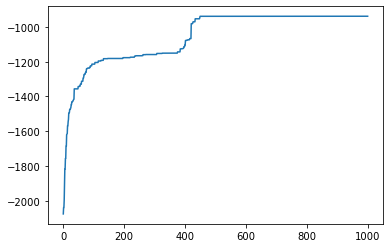

In [78]:
plt.plot(scores)